# Project 4: Behavioral Cloning

### Step 1: Loading Libraries 

In [1]:
import tensorflow as tf

In [2]:
import csv

import numpy as np
import pandas as pd 
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os


In [3]:
from math import ceil
from tqdm import tqdm
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Dropout,Flatten,Convolution2D,MaxPool2D, Lambda, Cropping2D
from imgaug import augmenters as iaa

Using TensorFlow backend.


### Step 2 : Load Track 1 and Track 2 Data

In [4]:
tracks_data = {'track_1' : 'data_v1.0',
        'track_1_reverse' : 'data_v1.0_reverse',
        'track_2' : 'data_v2.0',
        'track_2_reverse' : 'data_v2.0_reverse'
        }

In [5]:
def collect_data_path(path):
    samples = []
    with open(os.path.join(path,'driving_log.csv')) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)
    return samples

In [6]:
def collect_data(directory,samples):
    images = []
    steering_angles = []
    
    
    # Correction value of steering angles for Images from Left and Right Camera. 
    # This value was obtained after number of training and adjusting . 
    correction = 0.4
    
    for sample in tqdm(samples):
        
        center_image = os.path.join(directory,'IMG/') + sample[0].split('\\')[-1]
        left_image = os.path.join(directory,'IMG/') + sample[1].split('\\')[-1]
        right_image = os.path.join(directory,'IMG/') + sample[2].split('\\')[-1]

        steering_center = float(sample[3])
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        images.extend([center_image, left_image, right_image])
        steering_angles.extend([steering_center, steering_left, steering_right])
    return images, steering_angles

### Extracting Images and Steering Angles 

In [7]:
images, steering_angles = [], []

for value in tracks_data.values():
    samples = collect_data_path(value)
    images_data, steering_angles_data = collect_data(value,samples)
    images.extend(images_data)
    steering_angles.extend(steering_angles_data)

100%|██████████| 5230/5230 [00:00<00:00, 127903.45it/s]


In [8]:
assert len(images)== len(steering_angles),'Data uneven'

In [9]:
print('Total Images :', len(images))
print('Steering Angles :', len(steering_angles))

Total Images : 66624
Steering Angles : 66624


### Step 3: Split in to Training and Validation data

In [10]:
np.random.seed(0)

In [11]:
X_train, X_valid, y_train, y_valid=train_test_split(images, steering_angles,test_size=0.2,random_state=7)

In [12]:
print('Size of Training Set: ', len(X_train))
print('Size of Validation Set: ', len(X_valid))

Size of Training Set:  53299
Size of Validation Set:  13325


In [13]:
X_train[0]

'data_v1.0\\IMG/center_2020_03_08_15_06_48_640.jpg'

In [14]:
y_train[0]

0.0

In [15]:
mpimg.imread(X_train[0]).shape

(160, 320, 3)

Text(0.5, 1.0, 'Steering Angle: 0.0')

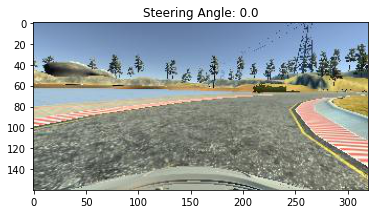

In [16]:
plt.imshow(mpimg.imread(X_train[0]))
plt.title('Steering Angle: {}'.format(y_train[0]))

### Step 4: Image Augmentation

Below model and augmentation techniques are referred from this paper:

http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

The image augmentation used below this cell is inspired by paper ,
'End to End Learning for Self-Driving Cars' from NVIDIA. (para 5.2)

    a. Random Image shift (Images will either be left/ right shift or up/ down shift i.e. Translation)
    b. Random Image rotation ( -25 deg to +25 deg)
    
Along with this 2 more image augmentation techniques are used they are , 

    a. Random Image flip ( steering angle will be changed and will be negative of what was before)
    b. Random Zoom ( factor of 1x to 1.3x - 30% Zoom)

In [17]:
def img_random_flip(image,steering_angle):
    image=cv2.flip(image,1)
    steering_angle=-steering_angle
    return image,steering_angle

In [18]:
def random_shift(image):
    pan=iaa.Affine(translate_percent={'x':(-0.1,0.1),'y':(-0.1,0.1)})
    image=pan.augment_image(image)
    return image

In [19]:
def random_zoom(image):
    zoom = iaa.Affine(scale=(1,1.3))
    image=zoom.augment_image(image)
    return image

In [20]:
def random_rotate(image):
    rotate = iaa.Affine(rotate=(-25, 25))
    image = rotate.augment_image(image)
    return image

Example Output of Augmentation Techniques

In [25]:
def display_image(image_1, angle_1, image_2, angle_2, text):
    f, ax = plt.subplots(1,2, figsize=(10,10))
    f.tight_layout()
    ax[0].imshow(image_1)
    ax[0].set_title('Original Image , Steering Angle {}'.format(angle_1))
    ax[1].imshow(image_2)
    ax[1].set_title('{} , Steering Angle {}'.format(text, angle_2))

a. Flip Image

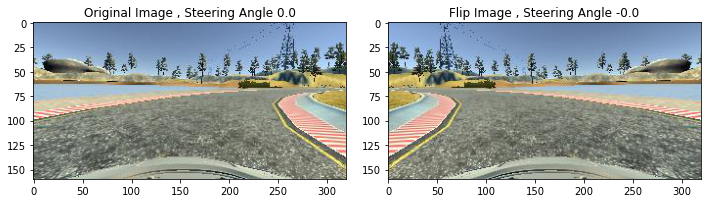

In [26]:
image_1 = mpimg.imread(X_train[0])
steering_angle_1 = y_train[0]
image_2, steering_angle_2 = img_random_flip(image_1, steering_angle_1)

display_image(image_1, steering_angle_1, image_2, steering_angle_2, text = 'Flip Image')

b. Translated Image

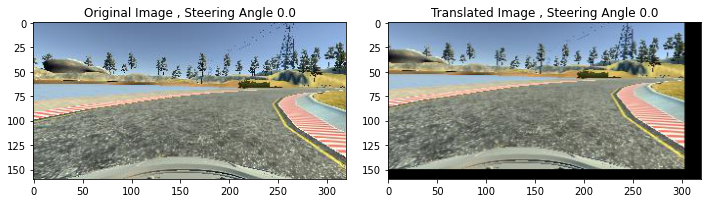

In [29]:
image_1 = mpimg.imread(X_train[0])
steering_angle_1 = y_train[0]
image_2 = random_shift(image_1)

display_image(image_1, steering_angle_1, image_2, steering_angle_1, text = 'Translated Image')

c. Zoomed Image

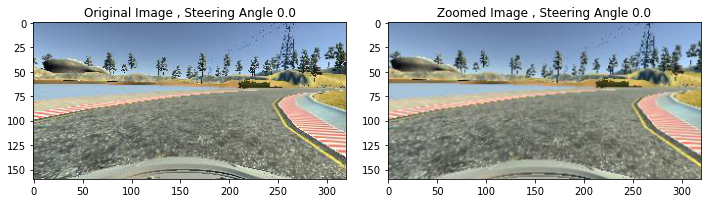

In [30]:
image_1 = mpimg.imread(X_train[0])
steering_angle_1 = y_train[0]
image_2 = random_zoom(image_1)

display_image(image_1, steering_angle_1, image_2, steering_angle_1, text = 'Zoomed Image')

d. Rotated Image

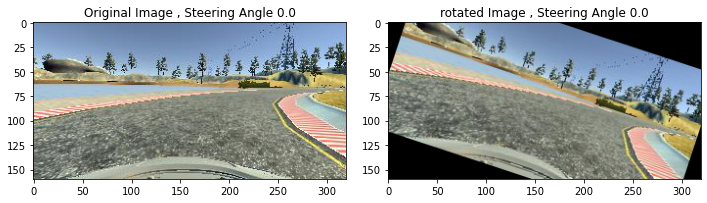

In [31]:
image_1 = mpimg.imread(X_train[0])
steering_angle_1 = y_train[0]
image_2 = random_rotate(image_1)

display_image(image_1, steering_angle_1, image_2, steering_angle_1, text = 'rotated Image')

Color Space Conversion

Text(0.5, 1.0, ' YUV image')

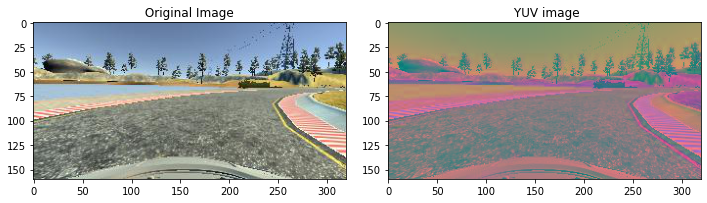

In [39]:
f, ax = plt.subplots(1,2, figsize=(10,10))
f.tight_layout()
ax[0].imshow(image_1)
ax[0].set_title(' Original Image ')
ax[1].imshow(cv2.cvtColor(image_1,cv2.COLOR_RGB2YUV))
ax[1].set_title(' YUV image')

### Data Generator 

In [32]:
def data_generator(X_train, y_train, batch_size, istraining = 1 ):
    num_samples = len(X_train)
    
    while True:

        for offset in range(0, num_samples, batch_size):
            x = X_train[offset:offset + batch_size]
            y = y_train[offset:offset + batch_size]
            
            images = []
            steering_angles = []
            
            for i in range(len(x)):
                
                image=mpimg.imread(x[i])
                
                # Cropping the top and bottom portion of the image , which are essentially jungle , trees and car hood
                image=image[60:135,:,:]
                
                # Images are converted to YUV image space as mentioned in the paper , YUV images yielded maximum result
                image=cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
                
                # Resizing the image to 200x66x3 as mentioned in the paper
                image=cv2.resize(image,(200,66))
                steering_angle = y[i]
                

                if istraining:
                    if np.random.rand() < 0.5:
                        image, steering_angle = img_random_flip(image, steering_angle)
                    if np.random.rand() < 0.5:
                        image = random_shift(image)
                    if np.random.rand() < 0.5:
                        image = random_zoom(image)
                    if np.random.rand() < 0.5:
                        image = random_rotate(image)
                
                images.append(image)
                steering_angles.append(steering_angle)
            
            X_t = np.array(images)
            y_t = np.array(steering_angles)
            
            yield shuffle(X_t, y_t)

In [33]:
batch_size = 32

In [34]:
train_generator = data_generator(X_train,y_train, batch_size= batch_size, istraining= 1)

In [35]:
validation_generator = data_generator(X_valid, y_valid, batch_size= batch_size, istraining= 0)

### Testing the Generator

In [25]:
X_t, y_t = next(train_generator)

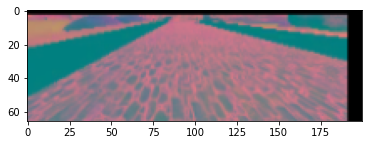

In [26]:
plt.imshow(X_t[0])

In [27]:
y_t[0]

0.4

### NVIDIA Model

In [28]:
def plot_loss(loss, val_loss):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training_data','validation_data'])
    plt.title('loss')
    plt.xlabel('Epoch')

In [43]:
def nvidia_model():
    model=Sequential()
    
    model.add(Lambda(lambda x: x/127.0 - 1., input_shape = (66,200,3)))
    #model.add(Cropping2D(cropping = ((60, 25), (0,0))))
    #model.add(Convolution2D(24,5,5,subsample=(2,2),input_shape=(66,200,3),activation='relu'))
    
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
    model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    
    optimizer=Adam(lr=1e-4)
    model.compile(loss='mse',optimizer=optimizer)
    return model

In [44]:
model=nvidia_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 18, 64)        

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:12: UserWarni

In [45]:
history = model.fit_generator(train_generator, steps_per_epoch=ceil(len(X_train)/batch_size),
                             validation_data = validation_generator, validation_steps = ceil(len(X_valid)/batch_size), epochs =30, verbose = True, shuffle = True)

Epoch 1/30
1666/1666 [==============================] - 166s 100ms/step - loss: 0.1703 - val_loss: 0.1105
Epoch 2/30
1666/1666 [==============================] - 171s 102ms/step - loss: 0.1349 - val_loss: 0.0850
Epoch 3/30
1666/1666 [==============================] - 176s 106ms/step - loss: 0.1223 - val_loss: 0.0875
Epoch 4/30
1666/1666 [==============================] - 176s 106ms/step - loss: 0.1177 - val_loss: 0.0834
Epoch 5/30
1666/1666 [==============================] - 180s 108ms/step - loss: 0.1152 - val_loss: 0.0751
Epoch 6/30
1666/1666 [==============================] - 183s 110ms/step - loss: 0.1129 - val_loss: 0.0710
Epoch 7/30
1666/1666 [==============================] - 184s 110ms/step - loss: 0.1112 - val_loss: 0.0698
Epoch 8/30
1666/1666 [==============================] - 183s 110ms/step - loss: 0.1101 - val_loss: 0.0673
Epoch 9/30
1666/1666 [==============================] - 173s 104ms/step - loss: 0.1092 - val_loss: 0.0662
Epoch 10/30
1666/1666 [=======================

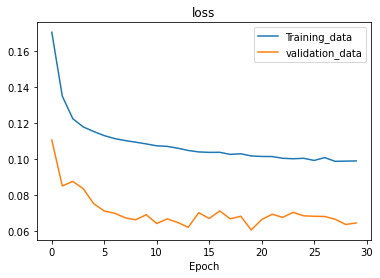

In [46]:
plot_loss(history.history['loss'], history.history['val_loss'])

In [47]:
model.save('C:/Users/asaga/Documents/CVND/Self Driving car NanoDegree/Project 4/model/model_v2.0.h5')